# Steps
1. Import persistent Training csv
2. Import non persistent Training csv
3. Drop benign data from persistent and non-persistent
4. Rename all labels in persistent sets to 'Persistent'
5. Rename all labels in non persistent set to 'Non persistent'
6. Combine the persistent and non persistent datasets
7. Train autogluon model
8. Test model
9. Check leaderboard
10. Check feature importance
11. Export model

In [28]:
cic_ids_features = ['src_port',
 'dst_port',
 'src2dst_packets',
 'dst2src_packets',
 'src2dst_bytes',
 'dst2src_bytes',
 'src2dst_duration_ms',
 'dst2src_duration_ms',
 'src2dst_rst_packets',
 'dst2src_rst_packets',
 'protocol',
 'bidirectional_duration_ms',
 'bidirectional_min_ps',
 'bidirectional_max_ps',
 'bidirectional_mean_ps',
 'bidirectional_stddev_ps',
 'src2dst_max_ps',
 'src2dst_min_ps',
 'src2dst_mean_ps',
 'src2dst_stddev_ps',
 'dst2src_max_ps',
 'dst2src_min_ps',
 'dst2src_mean_ps',
 'dst2src_stddev_ps',
 'bidirectional_mean_piat_ms',
 'bidirectional_stddev_piat_ms',
 'bidirectional_max_piat_ms',
 'bidirectional_min_piat_ms',
 'src2dst_mean_piat_ms',
 'src2dst_stddev_piat_ms',
 'src2dst_max_piat_ms',
 'src2dst_min_piat_ms',
 'dst2src_mean_piat_ms',
 'dst2src_stddev_piat_ms',
 'dst2src_max_piat_ms',
 'dst2src_min_piat_ms',
 'bidirectional_fin_packets',
 'bidirectional_syn_packets',
 'bidirectional_rst_packets',
 'bidirectional_psh_packets',
 'bidirectional_ack_packets',
 'bidirectional_urg_packets',
 'bidirectional_cwr_packets',
 'bidirectional_ece_packets',
 'src2dst_psh_packets',
 'dst2src_psh_packets',
 'src2dst_urg_packets',
 'dst2src_urg_packets',
 'Label']

# Imports

In [42]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt

# Import persistent and non persistent training sets

In [3]:
unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')
cic_ids = pd.read_csv('TRAIN_DFs/cic_ids_2017_train.csv')
persistent_testbed = pd.read_csv('TRAIN_DFs/persistent_testbed_train.csv')
non_persistent_testbed = pd.read_csv('TRAIN_DFs/non_persistent_testbed_train.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_13228\1923406082.py:1: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')


# Remove benign data

In [10]:
unraveled = unraveled[unraveled['Label'] != 'Benign']

unused = ['Infiltration - Portscan', 'Portscan', 'BENIGN']
cic_ids = cic_ids.loc[~cic_ids['Label'].isin(unused)]

# Label all persistent threats as Persistent

<Axes: >

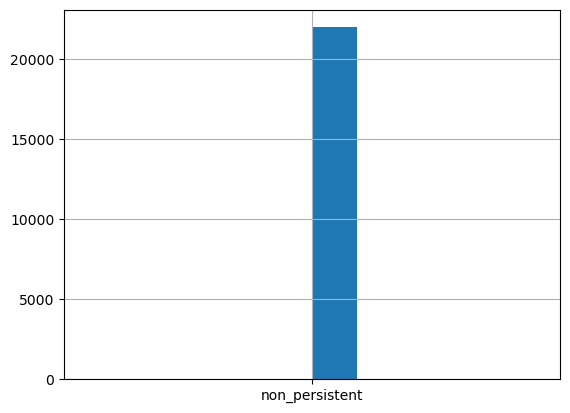

In [ ]:
unraveled['Label'] = 'persistent'
persistent_testbed['Label'] = 'persistent'

# Label all non persistent threats as non persistent

In [15]:
cic_ids['Label'] = 'non_persistent'
non_persistent_testbed['Label'] = 'non_persistent'

# Import testing data and relabel

In [34]:
cic_ids_test = pd.read_csv('TEST_DFs/cic_ids_2017_test.csv')
non_persistent_testbed_test = pd.read_csv('TEST_DFs/non_persistent_testbed_test.csv')
persistent_testbed_test = pd.read_csv('TEST_DFs/persistent_testbed_test.csv')
unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_13228\1948669035.py:4: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')


In [35]:
unraveled_test = unraveled_test[unraveled_test['Label'] != 'Benign']

unused = ['Infiltration - Portscan', 'Portscan', 'BENIGN']
cic_ids_test = cic_ids_test.loc[~cic_ids_test['Label'].isin(unused)]

In [36]:
unraveled_test['Label'] = 'persistent'
persistent_testbed_test['Label'] = 'persistent'

cic_ids_test['Label'] = 'non_persistent'
non_persistent_testbed_test['Label'] = 'non_persistent'

# Setup Autogluon - train model

In [50]:
results = pd.DataFrame(columns=['data_amount', 'mcc_cic_unraveled', 'mcc_testbed', 'mcc_combined', 'best_model'])

for amount_train_data in range(500, 5500, 500):

    combined_train_df = pd.concat([cic_ids[:amount_train_data], unraveled[:amount_train_data], persistent_testbed[:amount_train_data], non_persistent_testbed[:amount_train_data]])

    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df[cic_ids_features], presets='medium', fit_weighted_ensemble=False, included_model_types=['NN_TORCH', 'GBM', 'XGB', 'FASTAI', 'RF', 'XT', 'KNN'])

    testbed_test = pd.concat([persistent_testbed_test[cic_ids_features], non_persistent_testbed_test[cic_ids_features]])
    cic_unraveled_test = pd.concat([cic_ids_test, unraveled_test[cic_ids_features]])
    combined_test = pd.concat([testbed_test, cic_unraveled_test])

    testbed_results = predictor.evaluate(testbed_test)
    cic_unreaveled_results = predictor.evaluate(cic_unraveled_test)
    combined_results = predictor.evaluate(combined_test)

    combined_leaderboard = predictor.leaderboard(combined_test)

    new_row = {'data_amount': amount_train_data, 'mcc_cic_unraveled': cic_unreaveled_results['mcc'], 'mcc_testbed': testbed_results['mcc'], 'mcc_combined':combined_results['mcc'], 'best_model': combined_leaderboard.iloc[0]['model']}

    print(new_row)

    results.loc[len(results)] = new_row



No path specified. Models will be saved in: "AutogluonModels\ag-20250715_023926"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       50.09 GB / 63.72 GB (78.6%)
Disk Space Avail:   429.38 GB / 1906.98 GB (22.5%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250715_023926"
Train Data Rows:    2000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['non_persistent', 'persistent']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter d

{'data_amount': 500, 'mcc_cic_unraveled': np.float64(0.9966589925055276), 'mcc_testbed': np.float64(0.9330944403522713), 'mcc_combined': np.float64(0.9715233717568504), 'best_model': 'LightGBM'}


	0.968	 = Validation score   (mcc)
	0.9s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9801	 = Validation score   (mcc)
	0.75s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.964	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.964	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9523	 = Validation score   (mcc)
	0.34s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9601	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.8823	 = Validation score   (mcc)
	1.97s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.9802	 = Validation score   (mcc)
	0.57s	 = Trai

{'data_amount': 1000, 'mcc_cic_unraveled': np.float64(0.9905417052078993), 'mcc_testbed': np.float64(0.9382231312406054), 'mcc_combined': np.float64(0.9705718715682208), 'best_model': 'RandomForestEntr'}


	0.9768	 = Validation score   (mcc)
	1.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9734	 = Validation score   (mcc)
	0.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9633	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.96	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9567	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9567	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 8: early stopping
	0.8706	 = Validation score   (mcc)
	2.99s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.

{'data_amount': 1500, 'mcc_cic_unraveled': np.float64(0.9970756634460821), 'mcc_testbed': np.float64(0.9488323239068316), 'mcc_combined': np.float64(0.9780689516970617), 'best_model': 'LightGBM'}


	0.9726	 = Validation score   (mcc)
	0.92s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9776	 = Validation score   (mcc)
	0.91s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.97	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9726	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.975	 = Validation score   (mcc)
	0.38s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.97	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 9: early stopping
	0.9309	 = Validation score   (mcc)
	4.06s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.980

{'data_amount': 2000, 'mcc_cic_unraveled': np.float64(0.9912668617191861), 'mcc_testbed': np.float64(0.9448718098361177), 'mcc_combined': np.float64(0.9734551532172564), 'best_model': 'RandomForestEntr'}


	0.9642	 = Validation score   (mcc)
	0.96s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9643	 = Validation score   (mcc)
	0.91s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9662	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9662	 = Validation score   (mcc)
	0.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9662	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9662	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 9: early stopping
	0.8955	 = Validation score   (mcc)
	5.04s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0

{'data_amount': 2500, 'mcc_cic_unraveled': np.float64(0.9991631072139654), 'mcc_testbed': np.float64(0.9522130719035301), 'mcc_combined': np.float64(0.9804106685027151), 'best_model': 'LightGBM'}


	0.9801	 = Validation score   (mcc)
	0.95s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9801	 = Validation score   (mcc)
	1.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.97	 = Validation score   (mcc)
	0.43s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.97	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9684	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.97	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 4: early stopping
	0.8681	 = Validation score   (mcc)
	5.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.9818

{'data_amount': 3000, 'mcc_cic_unraveled': np.float64(0.9991631072139654), 'mcc_testbed': np.float64(0.9564125036195542), 'mcc_combined': np.float64(0.9821525336599982), 'best_model': 'XGBoost'}


	0.9886	 = Validation score   (mcc)
	1.21s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9886	 = Validation score   (mcc)
	1.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.98	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9829	 = Validation score   (mcc)
	0.43s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9814	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9786	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 3: early stopping
	0.8658	 = Validation score   (mcc)
	5.65s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0

{'data_amount': 3500, 'mcc_cic_unraveled': np.float64(0.9994419495530072), 'mcc_testbed': np.float64(0.9546581212564595), 'mcc_combined': np.float64(0.9816295760994989), 'best_model': 'LightGBM'}


	0.9838	 = Validation score   (mcc)
	1.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.98	 = Validation score   (mcc)
	1.26s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.98	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.98	 = Validation score   (mcc)
	0.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9775	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9763	 = Validation score   (mcc)
	0.4s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.8956	 = Validation score   (mcc)
	8.04s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0.9813	 = Validation score   (mcc)
	1.16s	 = Traini

{'data_amount': 4000, 'mcc_cic_unraveled': np.float64(0.9979098220100022), 'mcc_testbed': np.float64(0.9585768356894623), 'mcc_combined': np.float64(0.9824140229459248), 'best_model': 'LightGBM'}


	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9878	 = Validation score   (mcc)
	0.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9889	 = Validation score   (mcc)
	0.78s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9811	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.98	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9811	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9822	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.9137	 = Validation score   (mcc)
	9.07s	 = Training   runtime
	0.0s	 = Validat

{'data_amount': 4500, 'mcc_cic_unraveled': np.float64(0.9977707198710232), 'mcc_testbed': np.float64(0.9525855091172538), 'mcc_combined': np.float64(0.979809688796952), 'best_model': 'ExtraTreesGini'}


	0.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: KNeighborsDist ...
	0.967	 = Validation score   (mcc)
	0.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9851	 = Validation score   (mcc)
	1.86s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	0.9851	 = Validation score   (mcc)
	0.93s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.981	 = Validation score   (mcc)
	0.67s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.981	 = Validation score   (mcc)
	0.59s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.982	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.983	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not suppo

{'data_amount': 5000, 'mcc_cic_unraveled': np.float64(0.9997209137775033), 'mcc_testbed': np.float64(0.9589357876097262), 'mcc_combined': np.float64(0.9835290224532982), 'best_model': 'LightGBMLarge'}


<Axes: xlabel='data_amount', ylabel='value'>

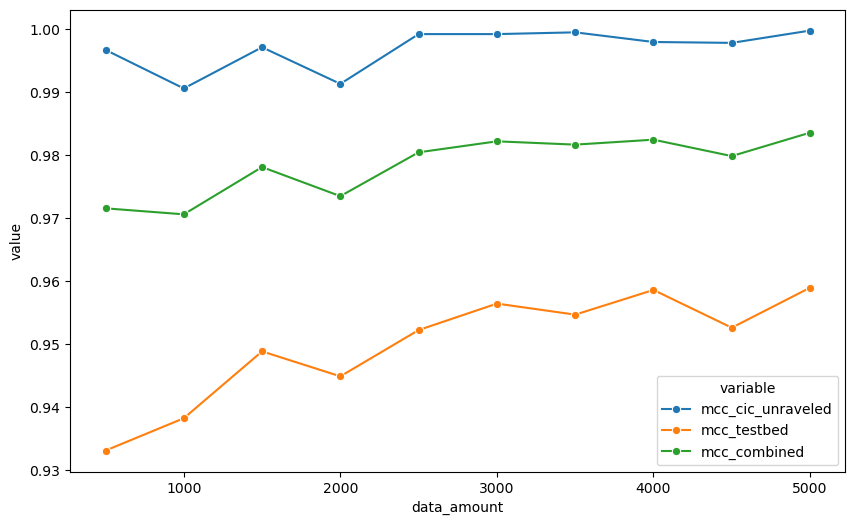

In [51]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = results.melt(id_vars='data_amount',
                          value_vars=['mcc_cic_unraveled', 'mcc_testbed', 'mcc_combined'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='data_amount', y='value', hue='variable', marker='o')

In [53]:
results

,data_amount,mcc_cic_unraveled,mcc_testbed,mcc_combined,best_model
0,500,0.996659,0.933094,0.971523,LightGBM
1,1000,0.990542,0.938223,0.970572,RandomForestEntr
2,1500,0.997076,0.948832,0.978069,LightGBM
3,2000,0.991267,0.944872,0.973455,RandomForestEntr
4,2500,0.999163,0.952213,0.980411,LightGBM
5,3000,0.999163,0.956413,0.982153,XGBoost
6,3500,0.999442,0.954658,0.981630,LightGBM
7,4000,0.997910,0.958577,0.982414,LightGBM
8,4500,0.997771,0.952586,0.979810,ExtraTreesGini
9,5000,0.999721,0.958936,0.983529,LightGBMLarge


In [55]:
combined_train_df = pd.concat([cic_ids[:3000], unraveled[:3000], persistent_testbed[:3000], non_persistent_testbed[:3000]])

predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df[cic_ids_features], presets='medium', fit_weighted_ensemble=False, included_model_types=['NN_TORCH', 'GBM', 'XGB', 'FASTAI', 'RF', 'XT', 'KNN'])

No path specified. Models will be saved in: "AutogluonModels\ag-20250715_033140"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       49.86 GB / 63.72 GB (78.3%)
Disk Space Avail:   428.74 GB / 1906.98 GB (22.5%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250715_033140"
Train Data Rows:    12000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['non_persistent', 'persistent']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter 

# Export model

In [56]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='persistent_non_persistent_model_finetune')

Cloned TabularPredictor located in 'c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250715_033140' to 'persistent_non_persistent_model_finetune'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="persistent_non_persistent_model_finetune")
Clone: Keeping minimum set of models required to predict with best model 'XGBoost'...
Deleting model KNeighborsUnif. All files under c:\Users\zac\Documents\github\modular_ids_framework\persistent_non_persistent_model_finetune\models\KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under c:\Users\zac\Documents\github\modular_ids_framework\persistent_non_persistent_model_finetune\models\KNeighborsDist will be removed.
Deleting model LightGBMXT. All files under c:\Users\zac\Documents\github\modular_ids_framework\persistent_non_persistent_model_finetune\models\LightGBMXT will be removed.
Deleting model LightGBM. All files under c:\Users\zac\Documents\github\modular_ids_framework\p